# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LCEL RAG Chain
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for a simple RAG system built on top of LangChain's blogs!

In [1]:
%pip install langchain_core langchain_openai langchain_community langchain-qdrant qdrant-client langsmith openai tiktoken cohere lxml -qU

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv()

OPEN_AI_API_KEY = os.getenv("OPENAI_API_KEY")
# os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = OPEN_AI_API_KEY

#### Asyncio Bug Handling

This is necessary for Colab.

In [3]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using Qdrant, Hugging Face, and LCEL

Now that we have a grasp on how LCEL works, and how we can use LangChain and Hugging Face to interact with our data - let's step it up a notch and incorporate Qdrant!

## LangChain Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

We'll use a SiteMapLoader to scrape the LangChain blogs - which will serve as our data for today!

### Data Collection

We'll be leveraging the `SitemapLoader` to load our PDF directly from the web!

In [4]:
from langchain.document_loaders import SitemapLoader

documents = SitemapLoader(web_path="https://blog.langchain.dev/sitemap-posts.xml").load()


USER_AGENT environment variable not set, consider setting it to identify your requests.
Fetching pages: 100%|##########| 220/220 [00:11<00:00, 18.83it/s]


In [5]:
print(f"Loading this docs {documents[1]} documents")

Loading this docs page_content='


LangChain Integration Docs: Find information faster with revamped pages & API references


















































Skip to content
















All Posts




Case Studies




In the Loop




LangChain




Docs




Changelog





Sign in
Subscribe



















LangChain Integration Docs: Find information faster with revamped pages & API references
See the latest updates to the LangChain integration docs, including a new standardized format and improved API references that can help you find relevant information faster.

3 min read
Aug 14, 2024





A large part of the LangChain ecosystem is its extensive collection of integrations. LangChain offers over 1,000 integrations for LLMs, vector stores, tools, document loaders, and more.Today, we’re announcing an overhaul of our integration documentation in both Python and JavaScript to make it more useful and accessible for the community. The key changes include:A standardized

### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 0,
    length_function = len,
)

split_chunks = text_splitter.split_documents(documents)

In [7]:
print(len(split_chunks))
print(split_chunks[0])

11531
page_content='How Podium optimized agent behavior and reduced engineering intervention by 90% with LangSmith


















































Skip to content
















All Posts' metadata={'source': 'https://blog.langchain.dev/customers-podium/', 'loc': 'https://blog.langchain.dev/customers-podium/', 'lastmod': '2024-08-15T14:00:05.000Z'}


Alright, now we have 516 ~200 token long documents.

Let's verify the process worked as intended by checking our max document length.

In [8]:
max_chunk_length = 0

for chunk in split_chunks:
  max_chunk_length = max(max_chunk_length, len(chunk.page_content))

print(max_chunk_length)

199


In [9]:
print(split_chunks)

[Document(metadata={'source': 'https://blog.langchain.dev/customers-podium/', 'loc': 'https://blog.langchain.dev/customers-podium/', 'lastmod': '2024-08-15T14:00:05.000Z'}, page_content='How Podium optimized agent behavior and reduced engineering intervention by 90% with LangSmith\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAll Posts'), Document(metadata={'source': 'https://blog.langchain.dev/customers-podium/', 'loc': 'https://blog.langchain.dev/customers-podium/', 'lastmod': '2024-08-15T14:00:05.000Z'}, page_content='Case Studies\n\n\n\n\nIn the Loop\n\n\n\n\nLangChain\n\n\n\n\nDocs\n\n\n\n\nChangelog\n\n\n\n\n\nSign in\nSubscribe'), Document(metadata={'source': 'https://blog.langchain.dev/customers-podium/', 'loc': 'https://blog.langchain.dev/customers-podium/', 'lastmod': '2024-08-15T14:00:05.000Z'}, page_content='How Podium optimized agent behavior and reduced engineering inte

Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [10]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

#Qdrant vector store imported from langchain_community.vectorstores
# you pass the split_chunks and assign them to documents, embedding_model and location
qdrant_vectorstore = Qdrant.from_documents(
    documents=split_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [11]:
#use assigned variable qdrant_vectorstore to create a retriever
qdrant_retriever = qdrant_vectorstore.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the LCEL we touched on earlier to create a RAG chain.

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

####🏗️ Activity #2:

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [12]:
from langchain.prompts import ChatPromptTemplate

base_rag_prompt_template = """\
Try answering queries based on the context provided otherwise say "I don't my Brah"

Context:
{context}

Question:
{question}
"""

base_rag_prompt = ChatPromptTemplate.from_template(base_rag_prompt_template)

We'll set our Generator - `gpt-4o` in this case - below!

In [13]:
from langchain_openai.chat_models import ChatOpenAI

base_llm = ChatOpenAI(model="gpt-4o-mini", tags=["base_llm"])

#### Our RAG Chain

Notice how we have a bit of a more complex chain this time - that's because we want to return our sources with the response.

Let's break down the chain step-by-step:

1. We invoke the chain with the `question` item. Notice how we only need to provide `question` since both the retreiver and the `"question"` object depend on it.
  - We also chain our `"question"` into our `retriever`! This is what ultimately collects the context through Qdrant.
2. We assign our collected context to a `RunnablePassthrough()` from the previous object. This is going to let us simply pass it through to the next step, but still allow us to run that section of the chain.
3. We finally collect our response by chaining our prompt, which expects both a `"question"` and `"context"`, into our `llm`. We also, collect the `"context"` again so we can output it in the final response object.

The key thing to keep in mind here is that we need to pass our context through *after* we've retrieved it - to populate the object in a way that doesn't require us to call it or try and use it for something else.

In [14]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": base_rag_prompt | base_llm, "context": itemgetter("context")}
)

Let's get a visual understanding of our chain!

In [15]:
!pip install -qU grandalf

In [16]:
print(retrieval_augmented_qa_chain.get_graph().draw_ascii())

          +---------------------------------+      
          | Parallel<context,question>Input |      
          +---------------------------------+      
                    **            **               
                  **                **             
                **                    **           
         +--------+                     **         
         | Lambda |                      *         
         +--------+                      *         
              *                          *         
              *                          *         
              *                          *         
  +----------------------+          +--------+     
  | VectorStoreRetriever |          | Lambda |     
  +----------------------+          +--------+     
                    **            **               
                      **        **                 
                        **    **                   
          +----------------------------------+     
          | 

Let's try another visual representation:

![image](https://i.imgur.com/Ad31AhL.png)

Let's test our chain out!

In [17]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What's new in LangChain v0.2?"})

In [18]:
response["response"].content

'LangChain v0.2 introduces improvements in stability and security over the previous version. This pre-release builds upon the foundation established in v0.1, enhancing the overall functionality of LangChain. For more detailed information, you can read the full announcement [here](https://blog.langchain.dev/langchain-v02-leap-to-stability/).'

In [19]:
for context in response["context"]:
  print("Context:")
  print(context)
  print("----")

Context:
page_content='read more about LangChain v0.2 here.' metadata={'source': 'https://blog.langchain.dev/documentation-refresh-for-langchain-v0-2/', 'loc': 'https://blog.langchain.dev/documentation-refresh-for-langchain-v0-2/', 'lastmod': '2024-05-31T16:43:51.000Z', '_id': '51839f179a1a4055968e43dda3ddf001', '_collection_name': 'b44fdbd634cc4c569d2799daeea6dd75'}
----
Context:
page_content='LangChain v0.2: A Leap Towards Stability
Today, we're announcing the pre-release of LangChain v0.2, which improves the stability and security of LangChain.

5 min read
May 10, 2024' metadata={'source': 'https://blog.langchain.dev/langchain-v02-leap-to-stability/', 'loc': 'https://blog.langchain.dev/langchain-v02-leap-to-stability/', 'lastmod': '2024-05-16T22:26:07.000Z', '_id': '83ff0526f636401fb84d374214225715', '_collection_name': 'b44fdbd634cc4c569d2799daeea6dd75'}
----
Context:
page_content='Four months ago, we released the first stable version of LangChain. Today, we are following up by ann

Let's see if it can handle a query that is totally unrelated to the source documents.

In [20]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What is the airspeed velocity of an unladen swallow?"})

In [21]:
response["response"].content

"I don't my Brah."

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [22]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangSmith - {unique_id}"
print(os.getenv("LANGCHAIN_PROJECT"))

LangSmith - 18447609


### LangSmith API

In order to use LangSmith - you will need a beta key, you can join the queue through the `Beta Sign Up` button on LangSmith's homepage!

Join [here](https://www.langchain.com/langsmith)

In [23]:
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY

Let's test our our first generation!

In [24]:
retrieval_augmented_qa_chain.invoke({"question" : "What REALLY IS LangSmith?"}, {"tags" : ["Demo Run"]})['response']

AIMessage(content='LangSmith is a framework built on top of LangChain, designed to track the inner workings of large language models (LLMs) and AI agents within products. It allows users to easily debug, evaluate, and manage LLM applications, integrating swiftly with LangChain.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 703, 'total_tokens': 756}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e', 'finish_reason': 'stop', 'logprobs': None}, id='run-f838dc13-d05c-4e4a-a1d5-29e0d382eca0-0', usage_metadata={'input_tokens': 703, 'output_tokens': 53, 'total_tokens': 756})

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.
It shows the run tree which display the parent child relationships  as well as the inputs and outputs of each run
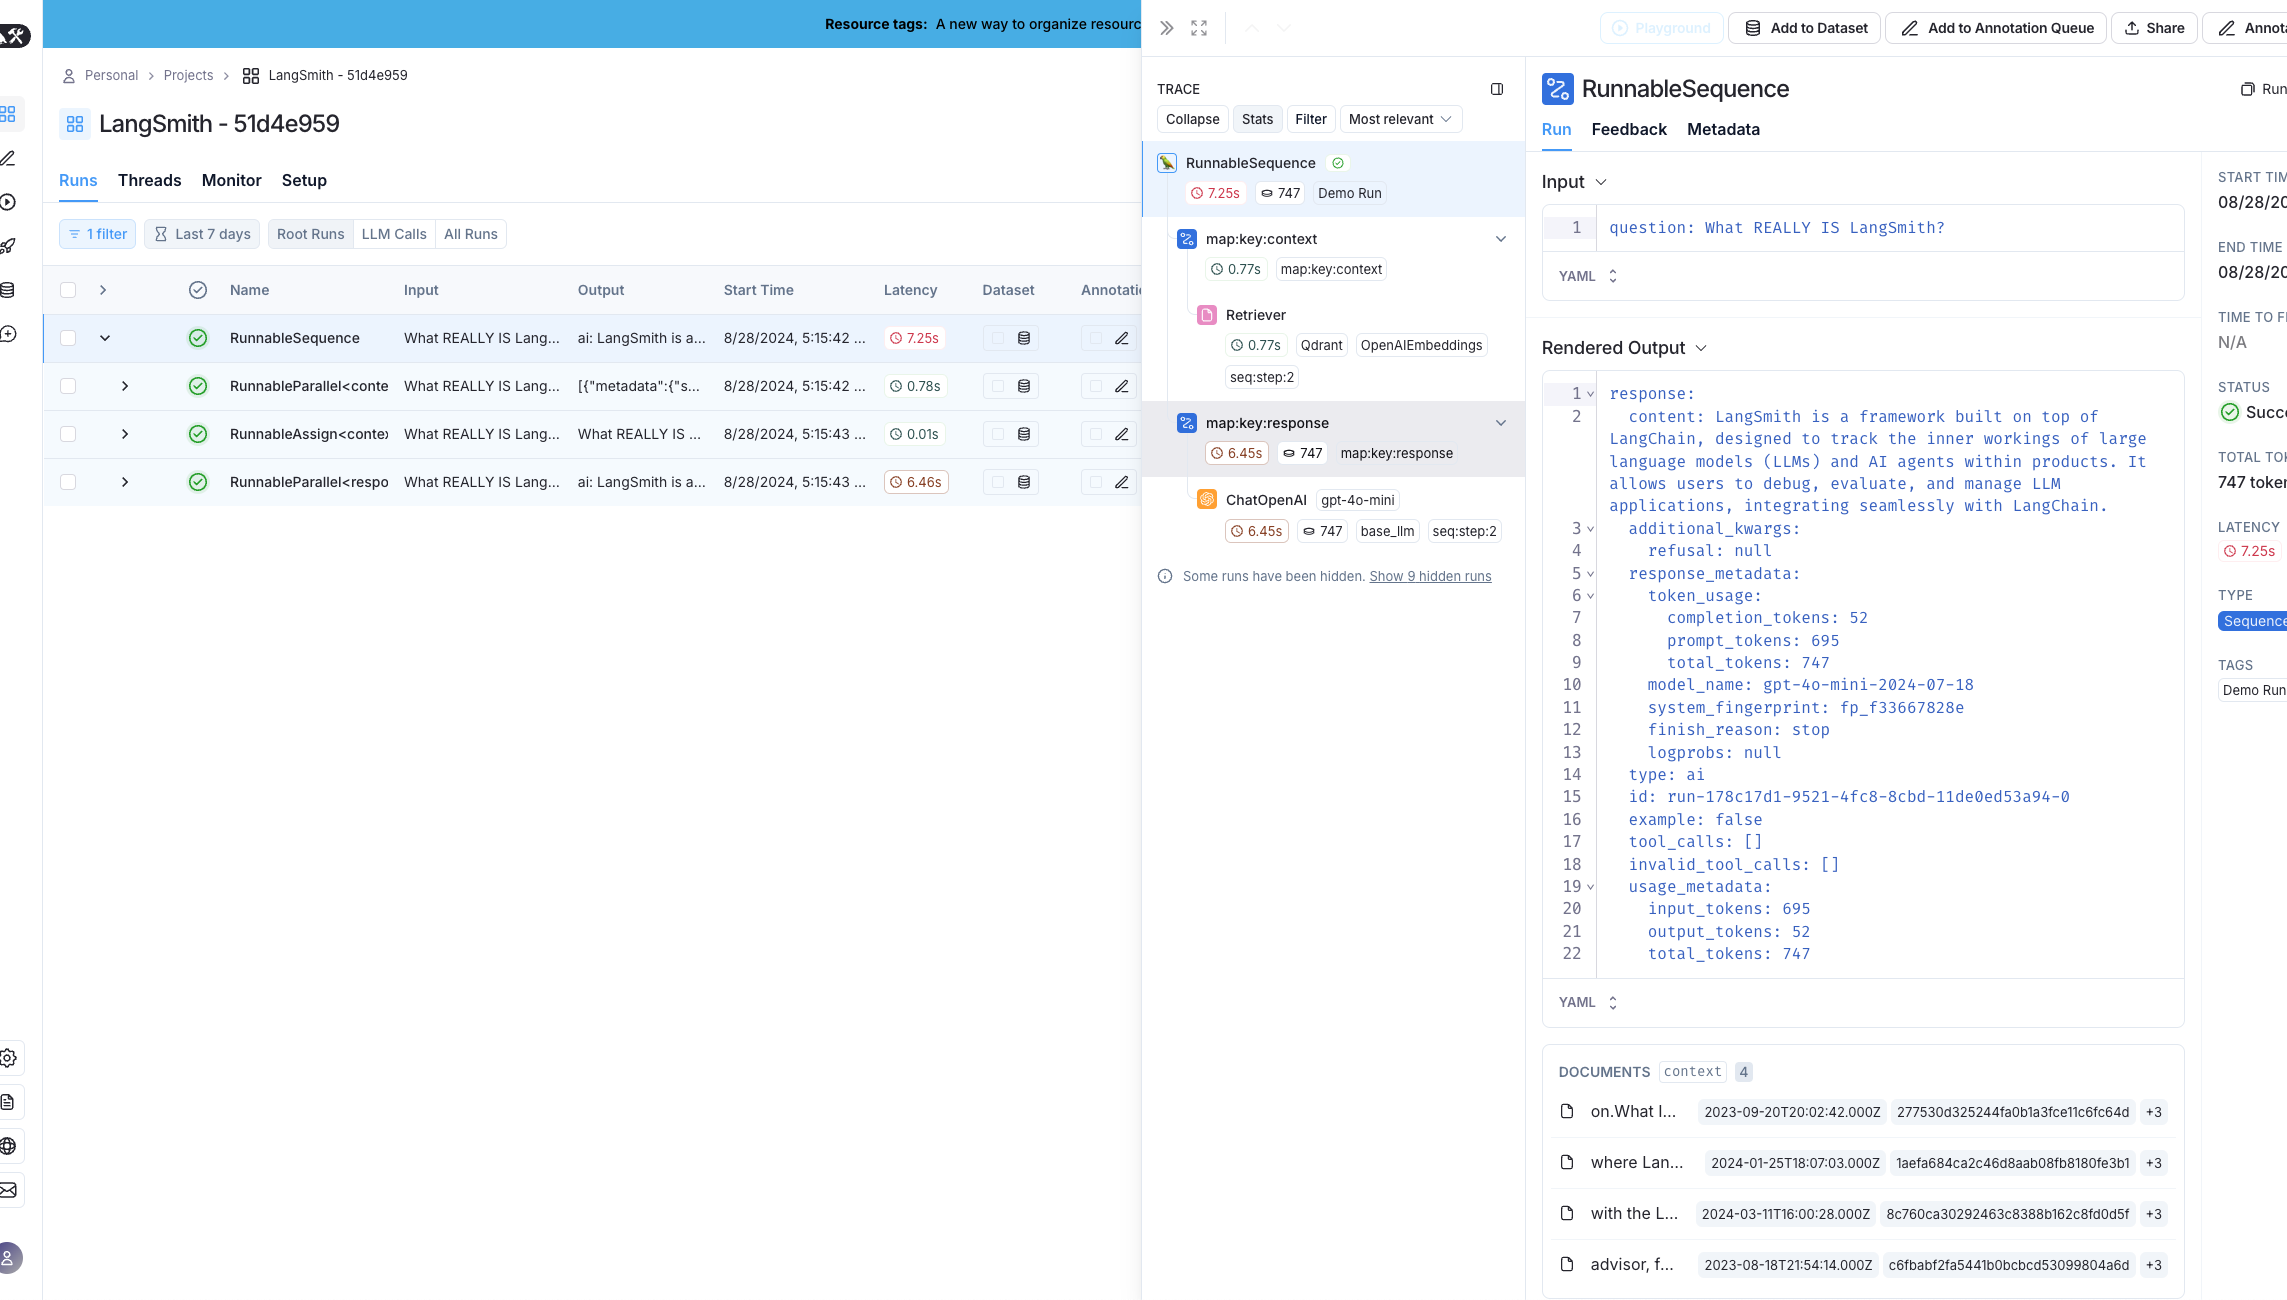

## Task 5: Loading Our Testing Set

In [25]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Cloning into 'DataRepository'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 84 (delta 23), reused 28 (delta 8), pack-reused 8 (from 1)
Receiving objects: 100% (84/84), 70.08 MiB | 2.08 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [26]:
import pandas as pd

test_df = pd.read_csv("DataRepository/langchain_blog_test_data.csv")

Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [27]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-demo-dataset-aie4-triples-v3-d"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="LangChain Blog Test Questions"
)

for triplet in test_df.iterrows():
  triplet = triplet[1]
  client.create_example(
      inputs={"question" : triplet["question"], "context": triplet["context"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

LangSmithConflictError: Conflict for /datasets. HTTPError('409 Client Error: Conflict for url: https://api.smith.langchain.com/datasets', '{"detail":"Dataset with this name already exists."}')

## Task 6: Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [ ]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

def prepare_context_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.inputs["context"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [ ]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

cot_qa_evaluator = LangChainStringEvaluator("cot_qa", prepare_data=prepare_context_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        }
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

base_rag_results = evaluate(
    retrieval_augmented_qa_chain.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        ],
    experiment_prefix="Base RAG Evaluation"
)

View the evaluation results for experiment: 'Base RAG Evaluation-9b0b8154' at:
https://smith.langchain.com/o/9c792ce1-9869-5aaf-ab8d-ff4e40d06af4/datasets/32ef18c6-36bf-4308-894a-b8d7b0756507/compare?selectedSessions=80f402f0-1f4e-4c28-b73a-82521e36c21a




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run ba22c4fe-4034-45d0-933f-a9b759801227: RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4 in organization org-423csqNX05oMlUXRwNNe9PtJ on tokens per min (TPM): Limit 10000, Used 9662, Requested 1187. Please try again in 5.094s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}")
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/llmops-course/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1313, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/llmops-course/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/ba

#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.